In [1]:
!pip install sastrawi

In [2]:
!pip install pandas scikit-learn nltk gensim

# Import Liblary

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import string
import nltk

from google.colab import drive
from io import StringIO
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Loading Dataset

## **Memanggil/mengambil dataset dari hasil scraping sebelumnnya**

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
shopee_reviews_df = pd.read_csv("/content/drive/MyDrive/dataset/Dicoding/shopee_reviews.csv")
shopee_reviews_df.head()

,userName,score,at,content
0,Pengguna Google,1,2025-04-05 00:30:39,Pengiriman Sangat Lambat Anjirr 🤬😡 Muak Aku Nu...
1,Pengguna Google,3,2025-04-04 23:16:47,"kenapa ya ga bisa ganti nomor telp ;(, tolong ..."
2,Pengguna Google,1,2025-04-04 22:45:48,Pengiriman ekspedisi JNT Express kenapa tiba t...
3,Pengguna Google,5,2025-04-04 17:53:35,bagus bagus tingkatkan lagi agar lebih bagus m...
4,Pengguna Google,5,2025-04-04 17:46:44,bagusss bangett tapi kalo bisa penjualny lebih...


## **Melihat Jumlah Baris**

In [6]:
jumlah_ulasan, jumlah_kolom = shopee_reviews_df.shape
print(f"Jumlah ulasan: {jumlah_ulasan}")
print(f"Jumlah kolom: {jumlah_kolom}")

Jumlah ulasan: 30000
Jumlah kolom: 4


## **Melihat Tipe Dataset yang Dipakai**

In [7]:
shopee_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  30000 non-null  object
 1   score     30000 non-null  int64 
 2   at        30000 non-null  object
 3   content   30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


## **Mengecek Jumlah Missing Value**

In [8]:
shopee_reviews_df.isna().sum()

,0
userName,0
score,0
at,0
content,0


## **Mengecek Jumlah Duplikasi**

In [9]:
shopee_reviews_df.duplicated().sum()

0

# Preprocessing Text

In [10]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

In [11]:
def casefoldingText(text):
    text = text.lower()
    return text

In [12]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [13]:
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa',"tdk",'gak','nya','na','sih','ku',"di","ga","woi","woii","woy","ya","gaa","loh","kah","hah","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [14]:
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
    return stemmed_text

In [15]:
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [16]:

slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget",
    "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau",
    "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin",
    "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya",
    "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa",
    "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman",
    "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena",
    "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan",
    "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong",
    "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya",
    "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu",
    "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan",
    "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir",
    "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos",
    "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis",
    "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin",
    "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional",
    "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana",
    "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap",
    "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih",
    "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau",
    "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur",
    "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan",
    "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan",
    "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru",
    "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil",
    "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal",
    "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep",
    "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall",
    "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka",
    "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista",
    "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa",
    "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "pringatkn": "peringatkan", "kmbali": "kembali", "app": "aplikasi",
    "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu",
    "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian",
    "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile",
    "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi",
    "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana",
    "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa",
    "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo",
    "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka",
    "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam",
    "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme",
    "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan",
    "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong",
    "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor",
    "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil",
    "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah",
    "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri",
    "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan",
    "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas",
    "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi",
    "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru",
    "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan",
    "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok",
    "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja",
    "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat",
    "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk",
    "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman",
    "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon",
    "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu",
    "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah",
    "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur",
    "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah",
    "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja",
    "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa",
    "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim",
    "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua",
    "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar",
    "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan",
    "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar",
    "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur",
    "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama",
    "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek",
    "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa",
    "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh",
    "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus",
    "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut",
    "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga",
    "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat",
    "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar",
    "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang",
    "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga",
    "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok",
    "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat",
    "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan",
    "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih",
    "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan",
    "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list",
    "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap",
    "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram",
    "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman",
    "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba",
    "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik",
    "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat",
    "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu",
    "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja",
    "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa",
    "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan",
    "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng",
    "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada",
    "shopeee": "shopee", "ga": "tidak", "lbih": "lebih", "tliti": "teliti", "shopy": "shopee", "shp": "shopee", "sukaa": "suka", "plss": "mohon", "akuu": "aku", "dr": "dari", "udh": "udh", "min": "admin", "mimin": "admin",
    "murce": "murah", "shoper": "shopee", "smain": "samain", "gimna": "gimana", "apk": "aplikasi", "cmn": "cuman", "pakaii": "pakai", "trus": "terus", "bngst": "kesal", "parahhhhhhhhhhhh": "kesal",  "diupdate": "perbarui", "gk": "tidak",
    "aplokasinya": "aplikasi", "Megecewakan": "mengecewakan", "sopi": "shopee", "sope": "shopee", "ngelag": "eror"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

In [17]:
shopee_reviews_df.head()

,userName,score,at,content
0,Pengguna Google,1,2025-04-05 00:30:39,Pengiriman Sangat Lambat Anjirr 🤬😡 Muak Aku Nu...
1,Pengguna Google,3,2025-04-04 23:16:47,"kenapa ya ga bisa ganti nomor telp ;(, tolong ..."
2,Pengguna Google,1,2025-04-04 22:45:48,Pengiriman ekspedisi JNT Express kenapa tiba t...
3,Pengguna Google,5,2025-04-04 17:53:35,bagus bagus tingkatkan lagi agar lebih bagus m...
4,Pengguna Google,5,2025-04-04 17:46:44,bagusss bangett tapi kalo bisa penjualny lebih...


In [18]:
shopee_reviews_df['text_clean'] = shopee_reviews_df['content'].apply(cleaningText)
shopee_reviews_df['text_casefoldingText'] = shopee_reviews_df['text_clean'].apply(casefoldingText)
shopee_reviews_df['text_slangwords'] = shopee_reviews_df['text_casefoldingText'].apply(fix_slangwords)
shopee_reviews_df['text_tokenizingText'] = shopee_reviews_df['text_slangwords'].apply(tokenizingText)
shopee_reviews_df['text_stopword'] = shopee_reviews_df['text_tokenizingText'].apply(filteringText)
shopee_reviews_df['text_akhir'] = shopee_reviews_df['text_stopword'].apply(toSentence)

In [19]:
shopee_reviews_df.head(20)

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,1,2025-04-05 00:30:39,Pengiriman Sangat Lambat Anjirr 🤬😡 Muak Aku Nu...,Pengiriman Sangat Lambat Anjirr Muak Aku Nung...,pengiriman sangat lambat anjirr muak aku nung...,pengiriman sangat lambat anjirr muak aku nungg...,"[pengiriman, sangat, lambat, anjirr, muak, aku...","[pengiriman, lambat, anjirr, muak, nunggu, per...",pengiriman lambat anjirr muak nunggu perna bel...
1,Pengguna Google,3,2025-04-04 23:16:47,"kenapa ya ga bisa ganti nomor telp ;(, tolong ...",kenapa ya ga bisa ganti nomor telp tolong don...,kenapa ya ga bisa ganti nomor telp tolong don...,kenapa iya tidak bisa ganti nomor telepon tolo...,"[kenapa, iya, tidak, bisa, ganti, nomor, telep...","[ganti, nomor, telepon, tolong, ekspedisi, spx...",ganti nomor telepon tolong ekspedisi spx lamba...
2,Pengguna Google,1,2025-04-04 22:45:48,Pengiriman ekspedisi JNT Express kenapa tiba t...,Pengiriman ekspedisi JNT Express kenapa tiba t...,pengiriman ekspedisi jnt express kenapa tiba t...,pengiriman ekspedisi jnt express kenapa tiba t...,"[pengiriman, ekspedisi, jnt, express, kenapa, ...","[pengiriman, ekspedisi, jnt, express, aktif]",pengiriman ekspedisi jnt express aktif
3,Pengguna Google,5,2025-04-04 17:53:35,bagus bagus tingkatkan lagi agar lebih bagus m...,bagus bagus tingkatkan lagi agar lebih bagus m...,bagus bagus tingkatkan lagi agar lebih bagus m...,bagus bagus tingkatkan lagi agar lebih bagus m...,"[bagus, bagus, tingkatkan, lagi, agar, lebih, ...","[bagus, bagus, tingkatkan, bagus, bagus]",bagus bagus tingkatkan bagus bagus
4,Pengguna Google,5,2025-04-04 17:46:44,bagusss bangett tapi kalo bisa penjualny lebih...,bagusss bangett tapi kalo bisa penjualny lebih...,bagusss bangett tapi kalo bisa penjualny lebih...,bagusss bangett tapi kalau bisa penjualny lebi...,"[bagusss, bangett, tapi, kalau, bisa, penjualn...","[bagusss, bangett, penjualny, amanah, lagii]",bagusss bangett penjualny amanah lagii
5,Pengguna Google,5,2025-04-04 17:45:16,Terima kasih Shopee aplikasi jual beli online ...,Terima kasih Shopee aplikasi jual beli online ...,terima kasih shopee aplikasi jual beli online ...,terima kasih shopee aplikasi jual beli online ...,"[terima, kasih, shopee, aplikasi, jual, beli, ...","[terima, kasih, shopee, aplikasi, jual, beli, ...",terima kasih shopee aplikasi jual beli online ...
6,Pengguna Google,5,2025-04-04 17:45:10,saya hanya ingin spinjam limit extra saya bisa...,saya hanya ingin spinjam limit extra saya bisa...,saya hanya ingin spinjam limit extra saya bisa...,saya hanya ingin spinjam limit extra saya bisa...,"[saya, hanya, ingin, spinjam, limit, extra, sa...","[spinjam, limit, extra, accord, kemarin, pakai]",spinjam limit extra accord kemarin pakai
7,Pengguna Google,1,2025-04-04 17:34:40,lelet lelet tau lelet ga lu lelet aplikasi mar...,lelet lelet tau lelet ga lu lelet aplikasi mar...,lelet lelet tau lelet ga lu lelet aplikasi mar...,lambat lambat tahu lambat tidak kamu lambat ap...,"[lambat, lambat, tahu, lambat, tidak, kamu, la...","[lambat, lambat, lambat, lambat, aplikasi, mar...",lambat lambat lambat lambat aplikasi marketpla...
8,Pengguna Google,5,2025-04-04 17:31:36,"banyakin voucher gratis ongkir min,banyak beli...",banyakin voucher gratis ongkir minbanyak beli ...,banyakin voucher gratis ongkir minbanyak beli ...,banyakin voucher gratis ongkos kirim minbanyak...,"[banyakin, voucher, gratis, ongkos, kirim, min...","[banyakin, voucher, gratis, ongkos, kirim, min...",banyakin voucher gratis ongkos kirim minbanyak...
9,Pengguna Google,5,2025-04-04 17:09:29,Belanja di Shopee dijamin memuaskan dan sangat...,Belanja di Shopee dijamin memuaskan dan sangat...,belanja di shopee dijamin memuaskan dan sangat...,belanja di shopee dijamin memuaskan dan sangat...,"[belanja, di, shopee, dijamin, memuaskan, dan,...","[belanja, shopee, dijamin, memuaskan, membantu...",belanja shopee dijamin memuaskan membantu kebu...


# Pelabelan

In [20]:
import requests
import csv

**Mengimport kamus lexicon**

In [21]:
lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

**Fungsi analisis sentimen**

In [22]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        score += lexicon_positive.get(word, 0) + lexicon_negative.get(word, 0)
    polarity = 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
    return score, polarity

**Pelabelan**

In [23]:
results = shopee_reviews_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
shopee_reviews_df['polarity_score'], shopee_reviews_df['polarity'] = zip(*results)
print(shopee_reviews_df['polarity'].value_counts())

polarity
negative    14185
positive    14056
neutral      1759
Name: count, dtype: int64


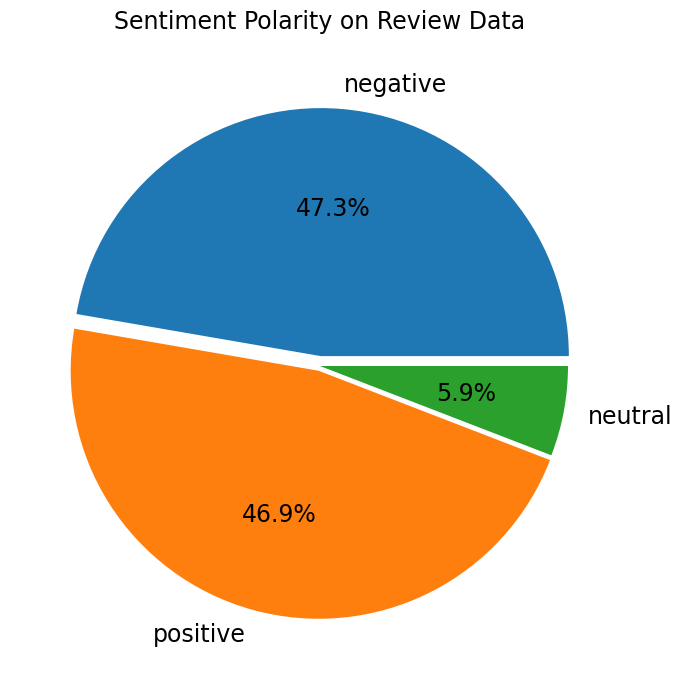

In [24]:
fig, ax = plt.subplots(figsize=(8, 10))
sizes = [count for count in shopee_reviews_df['polarity'].value_counts()]
labels = list(shopee_reviews_df['polarity'].value_counts().index)

explode = (0.04, 0.02, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 17})
ax.set_title('Sentiment Polarity on Review Data', fontsize=17, pad=20)
plt.show()

# Eksplorasi Label

In [25]:
pd.set_option('display.max_colwidth', 10000)
positive_tweets = shopee_reviews_df[shopee_reviews_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

In [26]:
pd.set_option('display.max_colwidth', 10000)
negative_tweets = shopee_reviews_df[shopee_reviews_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)
negative_tweets = negative_tweets[0:10]
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

In [27]:
pd.set_option('display.max_colwidth', 10000)
neutral_tweets = shopee_reviews_df[shopee_reviews_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=True)
neutral_tweets = neutral_tweets[0:10]
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

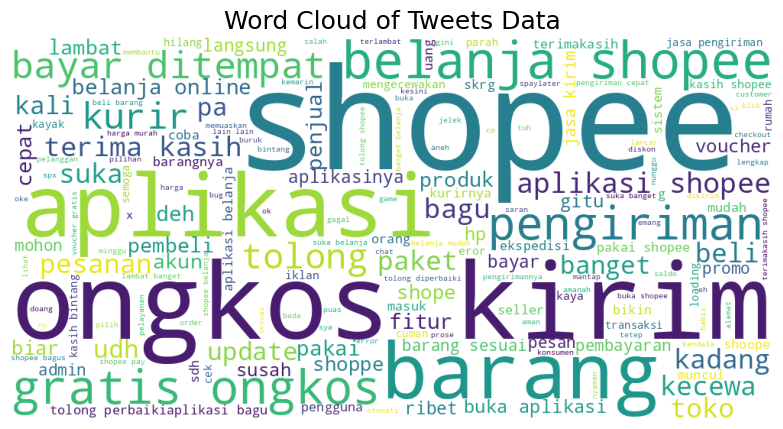

In [28]:
list_words = ''
for tweet in shopee_reviews_df['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

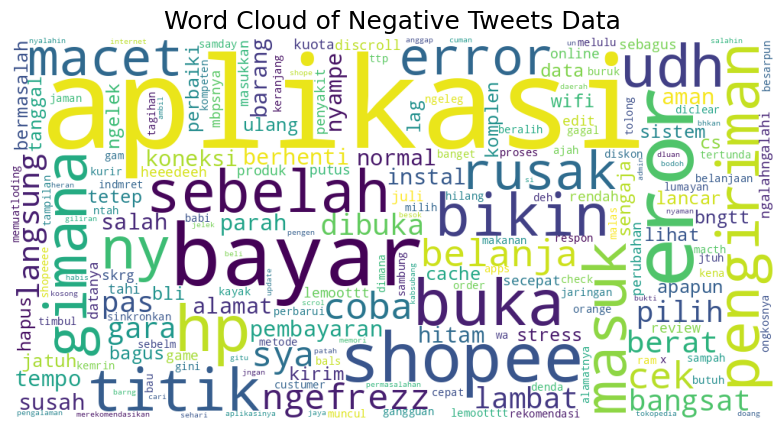

In [29]:
list_words = ''
for tweet in negative_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

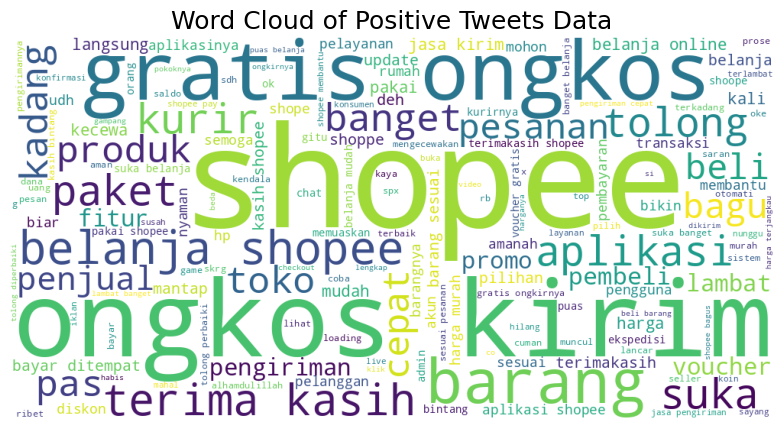

In [30]:
list_words = ''
for tweet in positive_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

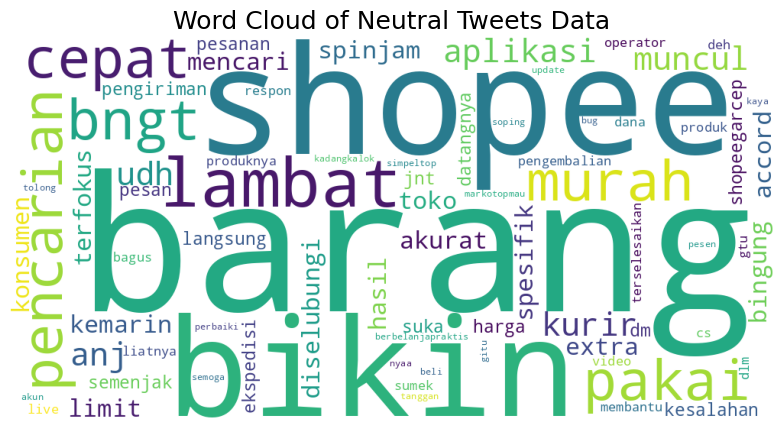

In [31]:
list_words = ''

for tweet in neutral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

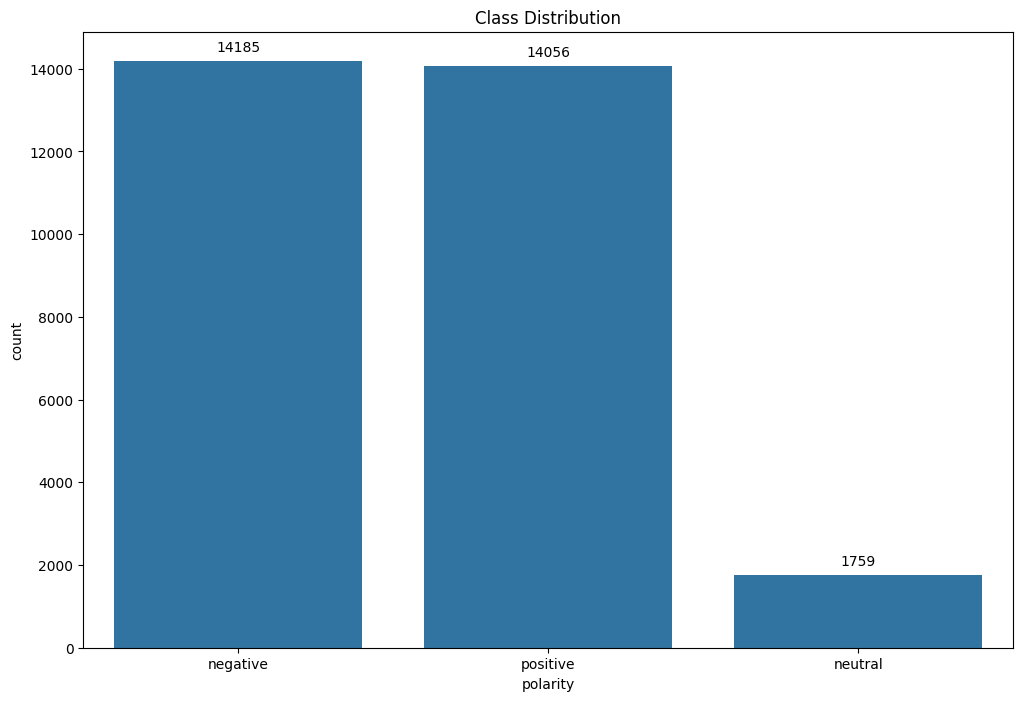

In [32]:
plt.figure(figsize=(12, 8))
class_dist_plot = sns.countplot(x='polarity', data=shopee_reviews_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

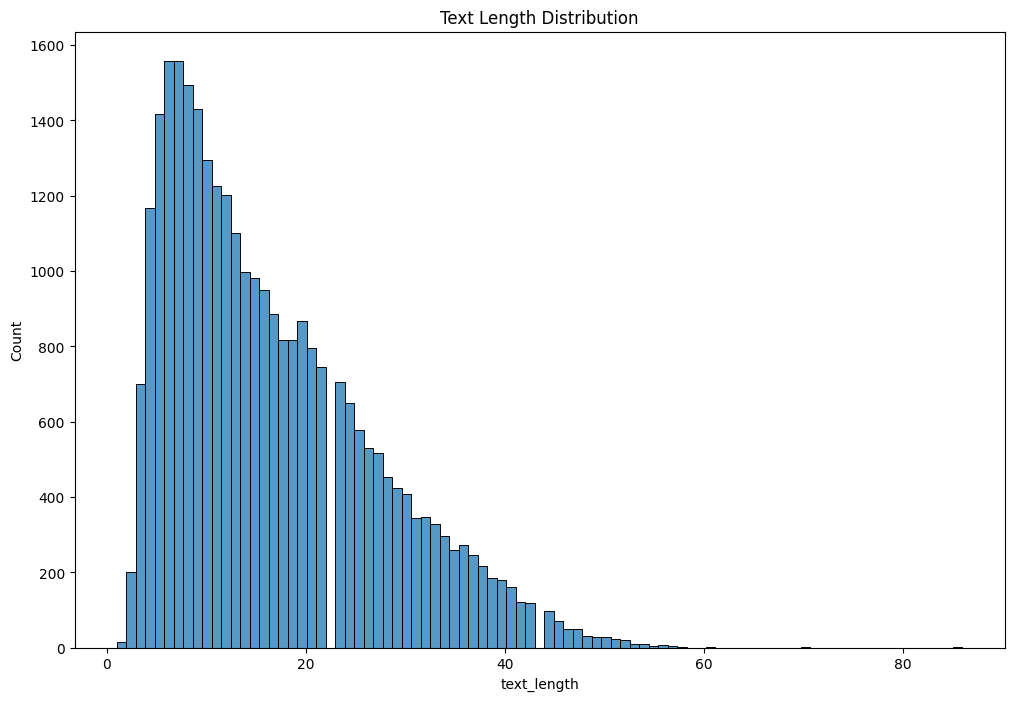

In [33]:
plt.show()
plt.figure(figsize=(12, 8))
shopee_reviews_df['text_length'] = shopee_reviews_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(shopee_reviews_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

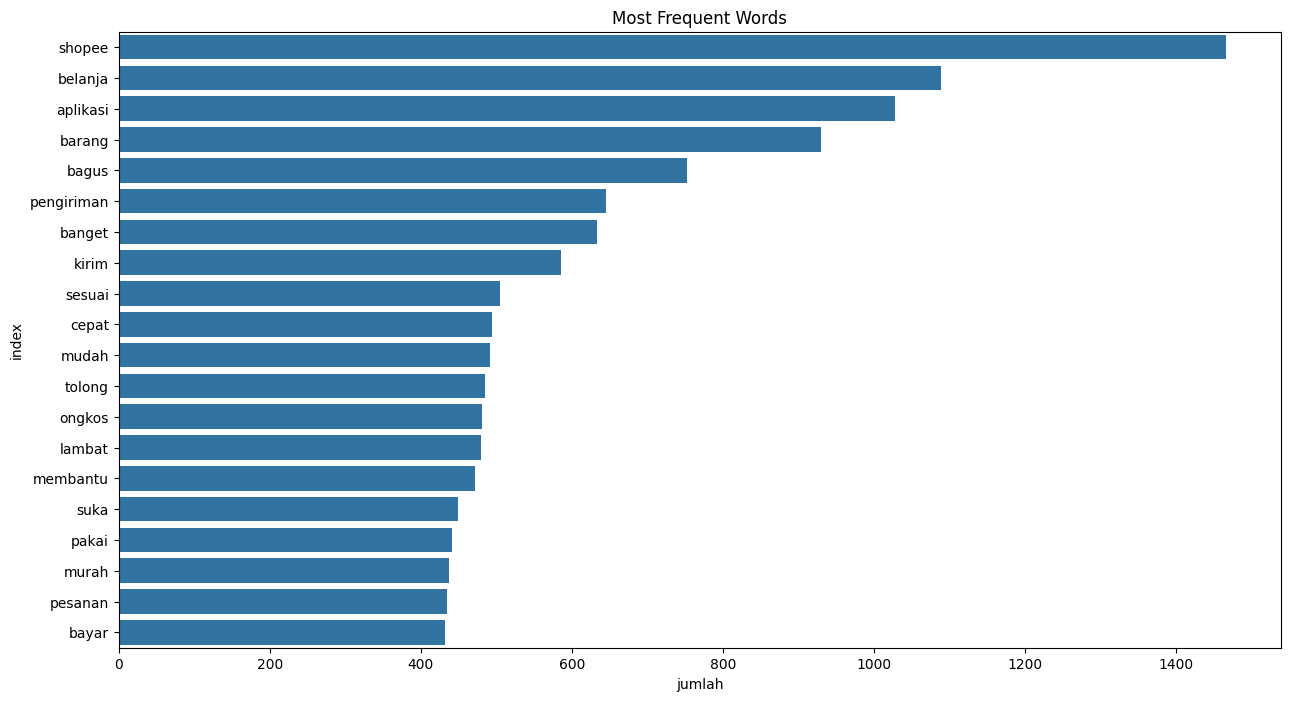

In [34]:
plt.figure(figsize=(15, 8))
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(shopee_reviews_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

# Data Splitting dan Ekstraksi Fitur dengan TF-IDF

In [35]:
shopee_reviews_df.head()

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,Pengguna Google,1,2025-04-05 00:30:39,Pengiriman Sangat Lambat Anjirr 🤬😡 Muak Aku Nunggu nya 😡🤬 Gak Perna Belajar Dari Sebelah Cemana Pengiriman Cepat 🤬😡 Kecewa Sangat Aku 😡🤬,Pengiriman Sangat Lambat Anjirr Muak Aku Nunggu nya Gak Perna Belajar Dari Sebelah Cemana Pengiriman Cepat Kecewa Sangat Aku,pengiriman sangat lambat anjirr muak aku nunggu nya gak perna belajar dari sebelah cemana pengiriman cepat kecewa sangat aku,pengiriman sangat lambat anjirr muak aku nunggu nya gak perna belajar dari sebelah cemana pengiriman cepat kecewa sangat aku,"[pengiriman, sangat, lambat, anjirr, muak, aku, nunggu, nya, gak, perna, belajar, dari, sebelah, cemana, pengiriman, cepat, kecewa, sangat, aku]","[pengiriman, lambat, anjirr, muak, nunggu, perna, belajar, sebelah, cemana, pengiriman, cepat, kecewa]",pengiriman lambat anjirr muak nunggu perna belajar sebelah cemana pengiriman cepat kecewa,-14,negative,12
1,Pengguna Google,3,2025-04-04 23:16:47,"kenapa ya ga bisa ganti nomor telp ;(, tolong dong ekspedisi spx kok jadi lelet beda sama jnt yang lumayan cepet",kenapa ya ga bisa ganti nomor telp tolong dong ekspedisi spx kok jadi lelet beda sama jnt yang lumayan cepet,kenapa ya ga bisa ganti nomor telp tolong dong ekspedisi spx kok jadi lelet beda sama jnt yang lumayan cepet,kenapa iya tidak bisa ganti nomor telepon tolong dong ekspedisi spx kok jadi lambat beda sama jnt yang lumayan cepat,"[kenapa, iya, tidak, bisa, ganti, nomor, telepon, tolong, dong, ekspedisi, spx, kok, jadi, lambat, beda, sama, jnt, yang, lumayan, cepat]","[ganti, nomor, telepon, tolong, ekspedisi, spx, lambat, beda, jnt, lumayan, cepat]",ganti nomor telepon tolong ekspedisi spx lambat beda jnt lumayan cepat,-1,negative,11
2,Pengguna Google,1,2025-04-04 22:45:48,Pengiriman ekspedisi JNT Express kenapa tiba tiba sudah tidak aktif,Pengiriman ekspedisi JNT Express kenapa tiba tiba sudah tidak aktif,pengiriman ekspedisi jnt express kenapa tiba tiba sudah tidak aktif,pengiriman ekspedisi jnt express kenapa tiba tiba sudah tidak aktif,"[pengiriman, ekspedisi, jnt, express, kenapa, tiba, tiba, sudah, tidak, aktif]","[pengiriman, ekspedisi, jnt, express, aktif]",pengiriman ekspedisi jnt express aktif,-6,negative,5
3,Pengguna Google,5,2025-04-04 17:53:35,bagus bagus tingkatkan lagi agar lebih bagus menjadi sangat bagus,bagus bagus tingkatkan lagi agar lebih bagus menjadi sangat bagus,bagus bagus tingkatkan lagi agar lebih bagus menjadi sangat bagus,bagus bagus tingkatkan lagi agar lebih bagus menjadi sangat bagus,"[bagus, bagus, tingkatkan, lagi, agar, lebih, bagus, menjadi, sangat, bagus]","[bagus, bagus, tingkatkan, bagus, bagus]",bagus bagus tingkatkan bagus bagus,-8,negative,5
4,Pengguna Google,5,2025-04-04 17:46:44,bagusss bangett tapi kalo bisa penjualny lebih amanah lagii,bagusss bangett tapi kalo bisa penjualny lebih amanah lagii,bagusss bangett tapi kalo bisa penjualny lebih amanah lagii,bagusss bangett tapi kalau bisa penjualny lebih amanah lagii,"[bagusss, bangett, tapi, kalau, bisa, penjualny, lebih, amanah, lagii]","[bagusss, bangett, penjualny, amanah, lagii]",bagusss bangett penjualny amanah lagii,3,positive,5


**Memisahkan data menjadi fitur (tweet) dan label (sentimen)**

In [36]:
X = shopee_reviews_df['text_akhir']
y = shopee_reviews_df['polarity']

**membagi data menjadi data latih dan data uji**

In [37]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Ekstraksi fitur dengan TF-IDF**

In [38]:
tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

**Ekstraksi fitur dengan Word2Vec**

In [39]:
X_train_tokens = [word_tokenize(text.lower()) for text in X_train_text]
X_test_tokens  = [word_tokenize(text.lower()) for text in X_test_text]

w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
def get_avg_w2v_vector(tokens, model, vector_size=100):
    valid_words = [word for word in tokens if word in model.wv]
    if not valid_words:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_words], axis=0)

X_train_w2v = np.array([get_avg_w2v_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v  = np.array([get_avg_w2v_vector(tokens, w2v_model) for tokens in X_test_tokens])

# Modeling (Penerapan Algoritma)

## Algoritma Logistic Regression dengan TF-IDF

In [40]:
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_tfidf_lr = lr_tfidf.predict(X_test_tfidf.toarray())
acc_tfidf_lr = accuracy_score(y_test, y_pred_tfidf_lr)

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr_tfidf = accuracy_score(lr_tfidf.predict(X_train_tfidf.toarray()), y_train)
accuracy_test_lr_tfidf = accuracy_score(y_pred_tfidf_lr, y_test)

print('Logistic Regression - accuracy_train_tfidf:', accuracy_train_lr_tfidf)
print('Logistic Regression - accuracy_test_tfidf:', accuracy_test_lr_tfidf)

Logistic Regression - accuracy_train_tfidf: 0.8703809523809524
Logistic Regression - accuracy_test_tfidf: 0.8607777777777778


## Algoritma Logistic Regression dengan Word2Vec

In [41]:
lr_word2vec = LogisticRegression(max_iter=1000)
lr_word2vec.fit(X_train_w2v, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_word2vec_lr = lr_word2vec.predict(X_test_w2v)
acc_word2vec_lr = accuracy_score(y_test, y_pred_word2vec_lr)

# Evaluasi akurasi model Logistic Regression
accuracy_train_ir_word2vec = accuracy_score(lr_word2vec.predict(X_train_w2v), y_train)
accuracy_test_ir_word2vec = accuracy_score(y_pred_word2vec_lr, y_test)
print('Logistic Regression - accuracy_train_word2vec:', accuracy_train_ir_word2vec)
print('Logistic Regression - accuracy_test_word2vec:', accuracy_test_ir_word2vec)

Logistic Regression - accuracy_train_word2vec: 0.7239047619047619
Logistic Regression - accuracy_test_word2vec: 0.7228888888888889


## Algoritma Support Vector Machine dengan TF-IDF

In [42]:
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_tfidf_svm = svm_tfidf.predict(X_test_tfidf.toarray())
acc_tfidf_svm = accuracy_score(y_test, y_pred_tfidf_svm)

# Evaluasi akurasi model SVM
accuracy_train_svm_tfidf = accuracy_score(svm_tfidf.predict(X_train_tfidf.toarray()), y_train)
accuracy_test_svm_tfidf = accuracy_score(y_pred_tfidf_svm, y_test)
print('SVM - accuracy_train_tfidf:', accuracy_train_svm_tfidf)
print('SVM - accuracy_test_tfidf:', accuracy_test_svm_tfidf)

SVM - accuracy_train_tfidf: 0.9206666666666666
SVM - accuracy_test_tfidf: 0.8582222222222222


## Algoritma Support Vector Machine dengan Word2Vec

In [43]:
svm_word2vec = SVC()
svm_word2vec.fit(X_train_w2v, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_word2vec_svm = svm_word2vec.predict(X_test_w2v)
acc_word2vec_svm = accuracy_score(y_test, y_pred_word2vec_svm)

# Evaluasi akurasi model SVM
accuracy_train_svm_word2vec = accuracy_score(svm_word2vec.predict(X_train_w2v), y_train)
accuracy_test_svm_word2vec = accuracy_score(y_pred_word2vec_svm, y_test)
print('SVM - accuracy_train_word2vec:', accuracy_train_svm_word2vec)
print('SVM - accuracy_test_word2vec:', accuracy_test_svm_word2vec)

SVM - accuracy_train_word2vec: 0.708047619047619
SVM - accuracy_test_word2vec: 0.711


## Algoritma Random Forest dengan TF-IDF

In [44]:
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_tfidf_rf = rf_tfidf.predict(X_test_tfidf.toarray())
acc_tfidf_rf = accuracy_score(y_test, y_pred_tfidf_rf)

# Evaluasi akurasi model Random Forest
accuracy_train_rf_tfidf = accuracy_score(rf_tfidf.predict(X_train_tfidf.toarray()), y_train)
accuracy_test_rf_tfidf = accuracy_score(y_pred_tfidf_rf, y_test)
print('Random Forest - accuracy_train_tfidf:', accuracy_train_rf_tfidf)
print('Random Forest - accuracy_test_tfidf:', accuracy_test_rf_tfidf)

Random Forest - accuracy_train_tfidf: 0.9974285714285714
Random Forest - accuracy_test_tfidf: 0.8044444444444444


## Algoritma Random Forest dengan Word2Vec

In [45]:
rf_word2vec = RandomForestClassifier()
rf_word2vec.fit(X_train_w2v, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_word2vec_rf = rf_word2vec.predict(X_test_w2v)
acc_word2vec_rf = accuracy_score(y_test, y_pred_word2vec_rf)

# Evaluasi akurasi model Random Forest
accuracy_train_rf_word2vec = accuracy_score(rf_word2vec.predict(X_train_w2v), y_train)
accuracy_test_rf_word2vec = accuracy_score(y_pred_word2vec_rf, y_test)
print('Random Forest - accuracy_train_word2vec:', accuracy_train_rf_word2vec)
print('Random Forest - accuracy_test_word2vec:', accuracy_test_rf_word2vec)

Random Forest - accuracy_train_word2vec: 1.0
Random Forest - accuracy_test_word2vec: 0.7017777777777777


## Algoritma Naive Bayes dengan TF-IDF

In [46]:
nb_tfidf = BernoulliNB()
nb_tfidf.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf.toarray())
acc_tfidf_nb = accuracy_score(y_test, y_pred_tfidf_nb)

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb_tfidf = accuracy_score(nb_tfidf.predict(X_train_tfidf.toarray()), y_train)
accuracy_test_nb_tfidf = accuracy_score(y_pred_tfidf_nb, y_test)
print('Naive Bayes - accuracy_train_tfidf:', accuracy_train_nb_tfidf)
print('Naive Bayes - accuracy_test_tfidf:', accuracy_test_nb_tfidf)

Naive Bayes - accuracy_train_tfidf: 0.7289523809523809
Naive Bayes - accuracy_test_tfidf: 0.7241111111111111


## Algoritma Naive Bayes dengan Word2vec

In [47]:
nb_word2vec = BernoulliNB()
nb_word2vec.fit(X_train_w2v, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_word2vec_nb = nb_word2vec.predict(X_test_w2v)
acc_word2vec_nb = accuracy_score(y_test, y_pred_word2vec_nb)

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb_word2vec = accuracy_score(nb_word2vec.predict(X_train_w2v), y_train)
accuracy_test_nb_word2vec = accuracy_score(y_pred_word2vec_nb, y_test)
print('Naive Bayes - accuracy_train_word2vec:', accuracy_train_nb_word2vec)
print('Naive Bayes - accuracy_test_word2vec:', accuracy_test_nb_word2vec)

Naive Bayes - accuracy_train_word2vec: 0.6264285714285714
Naive Bayes - accuracy_test_word2vec: 0.6271111111111111


## Evalusi Model Algoritma

In [48]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes'],
    'Accuracy Train': [accuracy_train_lr_tfidf, accuracy_train_svm_tfidf, accuracy_train_rf_tfidf, accuracy_train_nb_tfidf],
    'Accuracy Test': [accuracy_test_lr_tfidf, accuracy_test_svm_tfidf, accuracy_test_rf_tfidf, accuracy_test_nb_tfidf]
})

accuracy_test_only = results_df[['Model', 'Accuracy Test']]
print(accuracy_test_only)

                 Model  Accuracy Test
0  Logistic Regression       0.860778
1                  SVM       0.858222
2        Random Forest       0.804444
3          Naive Bayes       0.724111


In [49]:
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

print(accuracy_test_sorted)

                 Model  Accuracy Test
0  Logistic Regression       0.860778
1                  SVM       0.858222
2        Random Forest       0.804444
3          Naive Bayes       0.724111


# Uji Coba Prediksi Model

In [50]:
kalimat_baru = input("Masukkan kalimat baru: ")

kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)
X_kalimat_baru = tfidf.transform([kalimat_baru_final])

prediksi_sentimen = lr_tfidf.predict(X_kalimat_baru)
if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'negative':
    print("Sentimen kalimat baru adalah NEGATIF.")
else:
    print("Sentimen Kalimat baru adalah  NETRAL.")

Masukkan kalimat baru: aplikasi lambat
Sentimen kalimat baru adalah NEGATIF.
